In [143]:
folder_bub = 'F:/Brice/Maizena/ARG2-Couette/maizena41_20170925/'
file_bub = 'maizena41_20170925_02.txt'
folder_nobub = 'F:/Brice/Maizena/MCR301-Vibrations/Maizena41_20171205_planplan/RheoUS/'
file_nobub = 'maizena41_20171205_01_loading2.txt'

frec = 500
stress_factor    = 163.9   # Changent en fonction de la géométrie !!!
stress_offset    = 0.47    # To detect offsets, impose ramps / steps on sigma and gdot and perform a linear fit.
shearrate_factor = 3.1457  
shearrate_offset = 0.0067

In [144]:
import pandas as pd

def read_data(path):
    simple_names = {'El. Torque (mNm)':'torque', 'Angular Speed (rad s-1)':'omega', 'Voltage (mV)':'voltage', 'Temperature':'temp'}
    data = pd.read_csv(path, sep='\t')
    data = data.rename(mapper=simple_names, axis=1)
    data['time']  = data.index/frec
    data['gdot']  = data['omega']*shearrate_factor + shearrate_offset
    data['sigma'] = data['torque']*stress_factor + stress_offset
    return data

data_bub = read_data(folder_bub + file_bub)
data_nobub = read_data(folder_nobub + file_nobub)

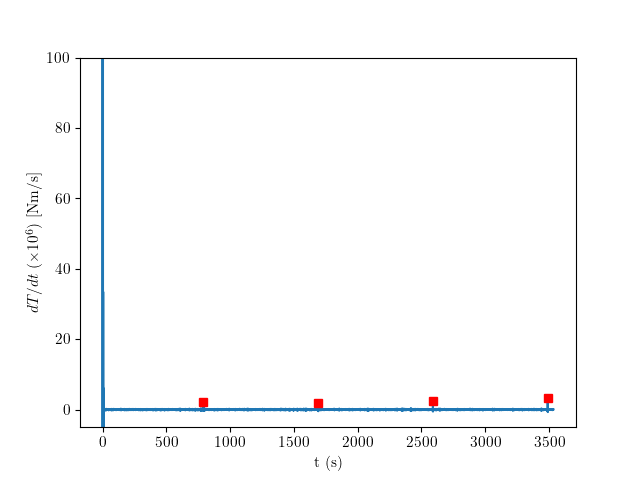

In [145]:
# Slicing things 
import numpy as np
import scipy.signal as spsi
import matplotlib.pyplot as plt
%matplotlib widget

def assign_steps(pks, nsamples=None):
    """MAKE_STEPS : Creates a steps list [0,0,0,0,1,1,1,...,N,N,N]
    (len 273 or more) from a list of indices, e.g. [12,36,59,...,273] 
    containing the boundaries of each step. Useful to combine with 
    `scipy.signal.find_peaks()`      
    """
    if nsamples == None:
        nsamples = np.max(pks)
    steps = np.zeros(nsamples)
    for pk in pks: steps[pk] = 1
    return np.cumsum(steps)

def slice(data, plot=False):
    """SLICE : Slices a pd.DataFrame based on periods
    in which the applied torque (column 'torque') is constant.
    Done using a Butterworth filter applied onto the time derivative of
    the torque. You can get a visualisation plot by setting the plot=True
    option.
    """
    b, a = spsi.butter(6, Wn=0.5, btype='lowpass', output='ba', fs=frec)
    dtorque = spsi.filtfilt(b=b, a=a, x=np.diff(data['torque']))
    pks, vals = spsi.find_peaks(dtorque, distance=10*frec, height=5e-7)
    data['step'] = assign_steps(pks, nsamples=len(dtorque)+1)
    
    if plot:
        fig, ax = plt.subplots()
        dtime = np.array(data['time'])[1:]
        ax.plot(dtime, 1e6*dtorque)
        ax.plot(dtime[pks], 1e6*dtorque[pks], 'rs')
        ax.set_ylabel('$dT/dt$ ($\\times 10^6$) [Nm/s]')
        ax.set_xlabel('t (s)')
        ax.set_ylim([-5,100])
        plt.show()

    return data

data_bub = slice(data_bub)
data_nobub = slice(data_nobub, plot=True)

avgs_nobub = {'step':[], 'sigma':[], 'gdot_avg':[], 'gdot_noUS':[], 'gdot_US':[]}


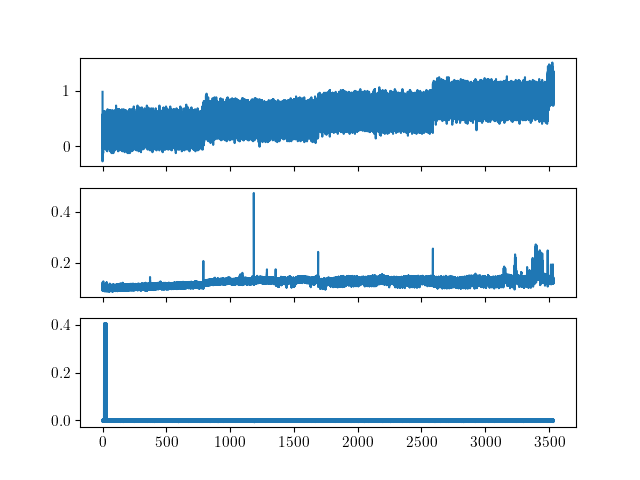

In [146]:
fig, ax = plt.subplots(nrows=3, sharex=True)

ax[0].plot(data_nobub['time'], data_nobub['sigma'])
ax[1].plot(data_nobub['time'], data_nobub['gdot'])
ax[2].plot(data_nobub['time'], data_nobub['voltage'])
plt.show()

C:\Users\SAINT-~1\AppData\Local\Temp/ipykernel_10568/3455790839.py:22: RuntimeWarning: Mean of empty slice
  avgs['gdot_US'].append(np.nanmean(gdot[is_us]))


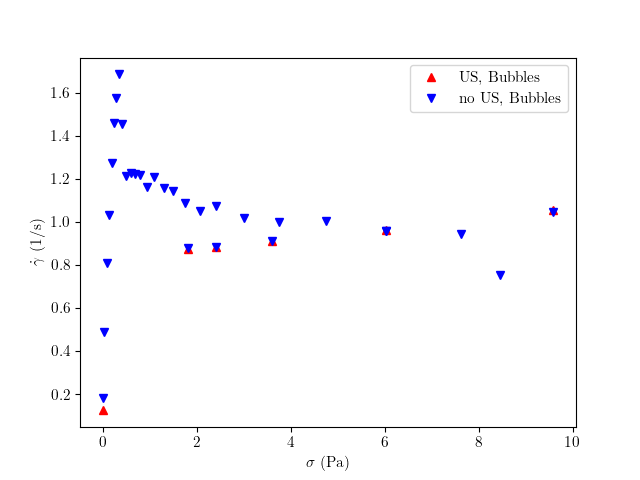

In [134]:
# Plot a single step thing

def make_avgs(data):
    """MAKE_AVGS : averages data on each step 
    / Does conditional averaging based on the application
    of ultrasound"""

    avgs = {'step':[], 'sigma':[], 'gdot_avg':[], 'gdot_noUS':[], 'gdot_US':[]}
    nsteps = int(np.max(data['step']))

    for step in range(1,nsteps):
 
        dat_stp = data[data['step'] == step]
        sig = dat_stp['sigma']
        gdot = dat_stp['gdot']
        vlt = dat_stp['voltage']
        is_us = np.abs(vlt) > 0.01

        avgs['step'].append(step)
        avgs['sigma'].append(np.nanmean(sig))
        avgs['gdot_avg'].append(np.nanmean(gdot))
        avgs['gdot_US'].append(np.nanmean(gdot[is_us]))
        avgs['gdot_noUS'].append(np.nanmean(gdot[np.logical_not(is_us)]))
    
    return avgs

avgs_bub = make_avgs(data_bub)
avgs_nobub = make_avgs(data_nobub)


new_params = {'text.usetex':True,
              'font.family':'serif',
              'font.size':11}
plt.rcParams.update(new_params)


fig, ax = plt.subplots()
ax.plot(avgs_nobub['sigma'], avgs_nobub['gdot_US'], 'r^', label='US, Bubbles')
ax.plot(avgs_nobub['sigma'], avgs_nobub['gdot_noUS'], 'bv', label='no US, Bubbles')
ax.set_ylabel('$\\dot\\gamma$ (1/s)')
ax.set_xlabel('$\\sigma$ (Pa)')
ax.legend()
plt.show()

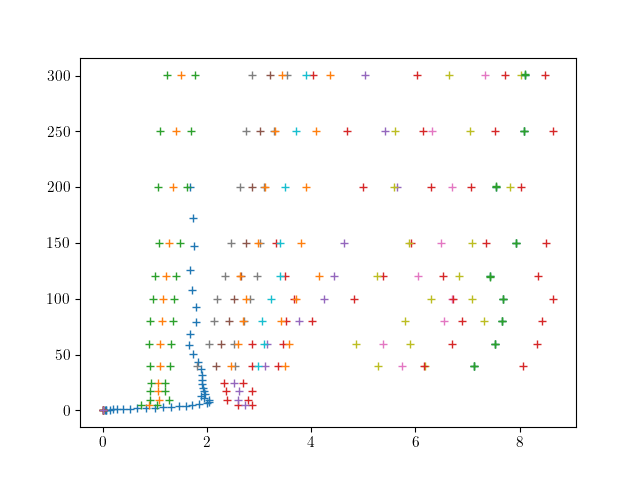

In [220]:
### Necromancing old FIG files from MATLAB

matfolder = 'F:/Brice/Maizena/ARG2-Couette/'
matfile = 'flowcurves_bubbles_nobubbles_20170905-06.fig'

from scipy.io import loadmat

data = loadmat(matfolder + matfile, struct_as_record=False, squeeze_me=True)
dat1 = data['hgS_070000']

# Figure 1

def browse_figure(fig_obj): 
    def is_axes(obj):
        return obj.type == 'axes'
    def is_line(obj):
        return obj.type == 'graph2d.lineseries'

    datas = []
    axes = list(filter(is_axes, fig_obj.children))
    for ax in axes:
        lines = list(filter(is_line, ax.children))
        for line in lines:            
            xdata = line.properties.XData
            ydata = line.properties.YData
            line_data = np.array((xdata, ydata))
            datas.append(line_data)
    return datas

datas_1 = browse_figure(dat1)

fig, axes = plt.subplots()
for obj in datas_1:
    plt.plot(obj[0], obj[1], '+')
plt.show()